In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels.formula.api as smf

# Target: measure the relationship between the change of housing rent price and entropy index of income_level groups

# 1.Data cleaning

# 1.1 clean dataset
This dataset is exported from Geolytics: Neighborhood Change Database (NACD)
(http://demographics.geolytics.com/ncdb2010/default.aspx)


### the dataset has been uploaded on:
 https://github.com/picniclin/NYC_yl5240/blob/master/geolytics_NYC_census_1990-2010.csv
 
or
https://drive.google.com/a/nyu.edu/file/d/0B2HY61hRpF-jV21KSTVsbi1wS3M/view?usp=sharing

In [2]:
df = pd.read_csv('/Users/apple/Desktop/NYC_yl5240/geolytics_NYC_census_1990-2010.csv')

In [3]:
df.shape

(2168, 146)

In [4]:
df.head()

,AREAKEY,STATE,STUSAB,INTPTLAT,INTPTLON,TCH_90_10,TCH_00_10,ZCTA5,TRCTPOP9,POVRAT9N,...,THY01001A,THY01251A,THY01501A,THY02001A,THY0M201A,MDHHY1A,MDVALHS1A,MCSMORT1A,MCSNMOR1A,MDGRENT1A
0,36005000100,36,NY,40.793492,-73.883532,0,0,11370.0,14303,0,...,0,0,0,0,0,0,0,0,0,0
1,36005000200,36,NY,40.804573,-73.856859,3,3,10473.0,2907,411,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,36,NY,40.808915,-73.850488,4,4,10473.0,2260,225,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,36,NY,40.818848,-73.858076,0,0,10473.0,5254,893,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,36,NY,40.800999,-73.909373,4,4,10454.0,1575,797,...,14,19,21,0,0,25093,0,0,539,870


In [5]:
list(df.columns)

['AREAKEY',
 'STATE',
 'STUSAB',
 'INTPTLAT',
 'INTPTLON',
 'TCH_90_10',
 'TCH_00_10',
 'ZCTA5',
 'TRCTPOP9',
 'POVRAT9N',
 'POVRAT9',
 'FAVINC9',
 'MDFAMY9',
 'FALTY109',
 'FALT159',
 'FALT209',
 'FALT259',
 'FALT309',
 'FALT359',
 'FALT409',
 'FALT499',
 'FALT609A',
 'FALT759A',
 'FALT1009',
 'FALT1259',
 'FALT1509',
 'FALTMXB9',
 'AVHHIN9',
 'MDHHY9',
 'OCCHU9',
 'VACHU9',
 'RNTOCC9',
 'OWNOCC9',
 'SPRNTOC9',
 'SPOWNOC9',
 'PRSOCU9',
 'PRSOWNU9',
 'PRSRNTU9',
 'MDVALHS9',
 'MCSMORT9',
 'MCSNMOR9',
 'MDGRENT9',
 'TRCTPOP0',
 'POVRAT0N',
 'POVRAT0',
 'FAVINC0',
 'MDFAMY0',
 'FAY0100',
 'FAY0150',
 'FAY0200',
 'FAY0250',
 'FAY0300',
 'FAY0350',
 'FAY0400',
 'FAY0450',
 'FAY0500',
 'FAY0600',
 'FAY0750',
 'FAY01000',
 'FAY01250',
 'FAY01500',
 'FAY02000',
 'FAY0M200',
 'AVHHIN0',
 'THY0100',
 'THY0150',
 'THY0200',
 'THY0250',
 'THY0300',
 'THY0350',
 'THY0400',
 'THY0450',
 'THY0500',
 'THY0600',
 'THY0750',
 'THY01000',
 'THY01250',
 'THY01500',
 'THY02000',
 'THY0M200',
 'MDHHY0',
 '

## make the column names readable

In [6]:
cols = df.columns.str.replace('TRCTPOP', 'pop')\
            .str.replace('MDFAMY','median_inc_fam_')\
            .str.replace('FAVINC', 'ave_inc_fam_')\
            .str.replace('MDHHY', 'median_inc_hh_')\
            .str.replace('AVHHIN', 'ave_inc_hh_')\
            .str.replace('FALTY', 'fam_inc_')\
            .str.replace('FALT', 'fam_inc_')\
            .str.replace('MXB', 'max_')\
            .str.replace('FAY0', 'fam_inc_')\
            .str.replace('fam_inc_M', 'fam_inc_max_')\
            .str.replace('THY0', 'hh_inc_' )\
            .str.replace('hh_inc_M', 'hh_inc_max_')\
            .str.replace('MDVALHS','median_house_value_')\
            .str.replace('MDGRENT', 'median_rent_' )\
            .str.replace('MCSMORT', 'owner_cost_mo_' )\
            .str.replace('MCSNMOR', 'owner_cost_no_mo_' )\
            .str.replace('OCCHU', 'occ_')\
            .str.replace('VACHU', 'vacant_')\
            .str.replace('RNTOCC','renter_occ_')\
            .str.replace('OWNOCC', 'owner_occ_')\
            .str.replace('SPRNTOC', 'spec_renter_occ_')\
            .str.replace('SPOWNOC', 'spec_owner_occ_')\
            .str.replace('PRSOCU', 'person_occ_')\
            .str.replace('PRSOWNU', 'person_owner_occ_')\
            .str.replace('PRSRNTU', 'person_renter_occ_')\
            .str.replace('POVRAT','poverty')\
            .str.replace('1A', '1')\
            .str.replace('9A', '9')
            
cols

Index(['AREAKEY', 'STATE', 'STUSAB', 'INTPTLAT', 'INTPTLON', 'TCH_90_10',
       'TCH_00_10', 'ZCTA5', 'pop9', 'poverty9N',
       ...
       'hh_inc_1001', 'hh_inc_1251', 'hh_inc_1501', 'hh_inc_2001',
       'hh_inc_max_201', 'median_inc_hh_1', 'median_house_value_1',
       'owner_cost_mo_1', 'owner_cost_no_mo_1', 'median_rent_1'],
      dtype='object', length=146)

In [7]:
df.columns = cols

df.rename(columns = {'AREAKEY' : 'census_tract',
                     'STATE':'state','STUSAB':'abb.',
                     'TCH_90_10':'tract_change_90', 'TCH_00_10':'tract_change_00',
                    'INTPTLAT':'lat', 'INTPTLON':'lon'}, inplace = True)
df.columns

Index(['census_tract', 'state', 'abb.', 'lat', 'lon', 'tract_change_90',
       'tract_change_00', 'ZCTA5', 'pop9', 'poverty9N',
       ...
       'hh_inc_1001', 'hh_inc_1251', 'hh_inc_1501', 'hh_inc_2001',
       'hh_inc_max_201', 'median_inc_hh_1', 'median_house_value_1',
       'owner_cost_mo_1', 'owner_cost_no_mo_1', 'median_rent_1'],
      dtype='object', length=146)

In [8]:
df = df.dropna()
df.ZCTA5 = df.ZCTA5.astype('int')
df.shape

(2157, 146)

In [9]:
## delete the observation, i.e. census tract, with 0 median rent or 0 median families income
df = df[~((df.median_rent_0 == 0)| (df.median_rent_9 == 0)|(df.median_rent_1 == 0)|\
         (df.median_inc_fam_9 == 0)| (df.median_inc_fam_9 == 0)|(df.median_inc_fam_1 == 0))]
## drop the redundant columns
df.drop(['state', 'abb.','tract_change_90','tract_change_00'], axis = 1, inplace = True)
df.head()

,census_tract,lat,lon,ZCTA5,pop9,poverty9N,poverty9,ave_inc_fam_9,median_inc_fam_9,fam_inc_109,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
1,36005000200,40.804573,-73.856859,10473,2907,411,0.142067,45267.28710,38711,29,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,40.808915,-73.850488,10473,2260,225,0.100089,43694.20068,40484,19,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,40.818848,-73.858076,10473,5254,893,0.179245,30042.84776,24732,142,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,40.800999,-73.909373,10454,1575,797,0.506032,23377.47813,24823,50,...,14,19,21,0,0,25093,0,0,539,870
5,36005002000,40.817580,-73.866096,10473,9110,3423,0.375741,25062.06250,18762,284,...,180,161,0,45,12,24939,398100,2185,715,455


In [10]:
df.shape

(2089, 142)

## 1.2 find the PUMA, NAT information for each census tract

### the CensusTract/NTA/PUMA Equivalencies table could be found on this [link](https://www1.nyc.gov/site/planning/data-maps/nyc-population/geographic-reference.page)
 the downloaded linkage is https://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/census2010/nyc2010census_tabulation_equiv.xlsx
 
This xlsx includes two tables. Split it into two csv by excel.
### The two csv files have been uploaded on:
https://github.com/picniclin/NYC_yl5240


In [11]:
df_conv1 = pd.read_csv('/Users/apple/Desktop/NYC_yl5240/data/2010CensusTract_PUMA_NTA.csv')
df_conv2 = pd.read_csv('/Users/apple/Desktop/NYC_yl5240/data/2010PUMA_NTA.csv')

In [12]:
## df_conv1 is the conversion table between census tract and PUMA/NTA
df_conv1.head()

,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name
0,Bronx,31000,3704,BX31,Allerton-Pelham Gardens
1,Bronx,31200,3704,BX31,Allerton-Pelham Gardens
2,Bronx,31400,3704,BX31,Allerton-Pelham Gardens
3,Bronx,31600,3704,BX31,Allerton-Pelham Gardens
4,Bronx,31800,3704,BX31,Allerton-Pelham Gardens


In [13]:
## df_conv2 is the conversion table between PUMA and NTA
df_conv2.head()

,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name
0,Bronx,3701,BX Community District 8,BX22,North Riverdale-Fieldston-Riverdale
1,Bronx,3701,BX Community District 8,BX28,Van Cortlandt Village
2,Bronx,3701,BX Community District 8,BX29,Spuyten Duyvil-Kingsbridge
3,Bronx,3702,BX Community District 12,BX03,Eastchester-Edenwald-Baychester
4,Bronx,3702,BX Community District 12,BX44,Williamsbridge-Olinville


In [14]:
len(df_conv1), len(df_conv2)

(2168, 219)

In [15]:
## In df_conv2, we could extract the PUMA list, including PUMA code and PUMA_CommunityDistrict
df_PUMA = df_conv2.iloc[:,1:3].drop_duplicates().reset_index(drop = True)
df_PUMA

,PUMA,PUMA_CommunityDistrict
0,3701,BX Community District 8
1,3702,BX Community District 12
2,3703,BX Community District 10
3,3704,BX Community District 11
4,3705,BX Community Districts 3 & 6
5,3706,BX Community District 7
6,3707,BX Community District 5
7,3708,BX Community District 4
8,3709,BX Community District 9
9,3710,BX Community Districts 1 & 2


In [16]:
df_conv3 = pd.DataFrame([['Bronx', '36005'],['Brooklyn','36047'],['Manhattan','36061'], 
              ['Queens','36081'], ['Staten Island', '36085']], columns=['Borough','BroCode'])
df_conv3

,Borough,BroCode
0,Bronx,36005
1,Brooklyn,36047
2,Manhattan,36061
3,Queens,36081
4,Staten Island,36085


In [17]:
df_conv = df_conv1.merge(df_conv2.rename(columns={'PUMA Code':'PUMA'}), 
               on = ['NTA_Code', 'NTA_Name', 'Borough', 'PUMA']).merge(df_conv3, on = 'Borough')

df_conv.head()

,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name,PUMA_CommunityDistrict,BroCode
0,Bronx,31000,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005
1,Bronx,31200,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005
2,Bronx,31400,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005
3,Bronx,31600,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005
4,Bronx,31800,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005


In [18]:
df_conv['census_tract']  = (df_conv.BroCode +\
                        df_conv['2010CensusTract'].apply(lambda x : str(x).zfill(6))).astype(int)

In [19]:
df_conv = df_conv.iloc[:,[0,-1,2,-3,3,4]]
df_conv.head()

,Borough,census_tract,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name
0,Bronx,36005031000,3704,BX Community District 11,BX31,Allerton-Pelham Gardens
1,Bronx,36005031200,3704,BX Community District 11,BX31,Allerton-Pelham Gardens
2,Bronx,36005031400,3704,BX Community District 11,BX31,Allerton-Pelham Gardens
3,Bronx,36005031600,3704,BX Community District 11,BX31,Allerton-Pelham Gardens
4,Bronx,36005031800,3704,BX Community District 11,BX31,Allerton-Pelham Gardens


In [20]:
len(df_conv)

2167

In [21]:
# check does the conversion table contain all the census tract in dataset df
len(set(df['census_tract']) - set(df_conv['census_tract'])), \
len(set(df_conv['census_tract']) - set(df['census_tract']) ), \
len(set(df['census_tract']))

(0, 78, 2089)

#### Yes, the conversion table contain all the census tract in dataset df.

## 1.3 conbine the conversion table into dataset, to add the PUMA and NTA information

In [22]:
df_all = df.merge(df_conv, on = 'census_tract')

df_all.head()

,census_tract,lat,lon,ZCTA5,pop9,poverty9N,poverty9,ave_inc_fam_9,median_inc_fam_9,fam_inc_109,...,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name
0,36005000200,40.804573,-73.856859,10473,2907,411,0.142067,45267.28710,38711,29,...,59826,392500,2661,650,1273,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park
1,36005000400,40.808915,-73.850488,10473,2260,225,0.100089,43694.20068,40484,19,...,71968,393700,2206,679,1330,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park
2,36005001600,40.818848,-73.858076,10473,5254,893,0.179245,30042.84776,24732,142,...,30355,378100,2500,649,823,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park
3,36005001900,40.800999,-73.909373,10454,1575,797,0.506032,23377.47813,24823,50,...,25093,0,0,539,870,Bronx,3710,BX Community Districts 1 & 2,BX39,Mott Haven-Port Morris
4,36005002000,40.817580,-73.866096,10473,9110,3423,0.375741,25062.06250,18762,284,...,24939,398100,2185,715,455,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park


In [23]:
# change the colomn location of df_cov's colomns
df_all = pd.concat([df_all.iloc[:,[0]], df_all.iloc[:,-5:], df_all.iloc[:,1:-5]], axis = 1)
df_all.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5,pop9,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
0,36005000200,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473,2907,...,152,203,48,68,11,59826,392500,2661,650,1273
1,36005000400,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473,2260,...,255,97,161,96,73,71968,393700,2206,679,1330
2,36005001600,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473,5254,...,171,20,38,20,0,30355,378100,2500,649,823
3,36005001900,Bronx,3710,BX Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454,1575,...,14,19,21,0,0,25093,0,0,539,870
4,36005002000,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473,9110,...,180,161,0,45,12,24939,398100,2185,715,455


In [24]:
df_all.shape, df.shape

((2089, 147), (2089, 142))

# 2. split the dataset into several sub-tables

## 2.1 Geographies data table
according to http://guides.newman.baruch.cuny.edu/nyc_data/nbhoods, New York City neighborhood census data could use Public Use Microdata Areas (PUMAs).


In [25]:
# the sub-table of census tract information, including census tract id, latitude, longitude, and ZCTA.
df_tract = df_all.iloc[:, :9]
df_tract.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5
0,36005000200,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473
1,36005000400,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473
2,36005001600,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473
3,36005001900,Bronx,3710,BX Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454
4,36005002000,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473


## 2.2 Tables for different years

In [26]:
df_1990 = df.iloc[:, 8:42]
df_2000 = df.iloc[:, 42:94]
df_2010 = df.iloc[:, 94:]
df_1990.shape, df_2000.shape, df_2010.shape

((2089, 34), (2089, 52), (2089, 48))

## 2.3 Income Tables

In [27]:
# the sub-table of median/average families/households income
df_income = df.loc[:,df.columns[(df.columns.str.startswith('median_inc_')) |\
                              (df.columns.str.startswith('ave_inc_'))]]
df_income.head()  

,ave_inc_fam_9,median_inc_fam_9,ave_inc_hh_9,median_inc_hh_9,ave_inc_fam_0,median_inc_fam_0,ave_inc_hh_0,median_inc_hh_0,ave_inc_fam_1,median_inc_fam_1,ave_inc_hh_1,median_inc_hh_1
1,45267.28710,38711,41034.78595,31632,50763.54348,50817,48547.32784,42539,67363.981,58368,66324.981,59826
2,43694.20068,40484,41850.02374,36506,48306.41829,41019,45697.79035,39111,86056.373,73148,82305.160,71968
3,30042.84776,24732,27803.12012,22739,36442.53563,30104,31610.56070,24552,43473.490,33555,38629.904,30355
4,23377.47813,24823,19303.58696,11215,31360.47431,23671,27995.65217,22772,35995.455,25489,33907.328,25093
5,25062.06250,18762,22262.06940,14765,26817.80645,19694,24885.52589,14691,41842.527,30817,35687.455,24939


In [28]:
df_income.describe()

,ave_inc_fam_9,median_inc_fam_9,ave_inc_hh_9,median_inc_hh_9,ave_inc_fam_0,median_inc_fam_0,ave_inc_hh_0,median_inc_hh_0,ave_inc_fam_1,median_inc_fam_1,ave_inc_hh_1,median_inc_hh_1
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.00000,2089.000000,2089.000000,2089.000000
mean,46240.797301,37689.401628,39246.703235,31309.411202,63576.869583,48874.026807,54229.582025,40628.821446,85376.28443,66207.958353,72345.813173,54703.689325
std,28606.446820,18760.425689,19565.189172,13562.873547,45058.370638,28645.098401,29038.210224,18527.299709,62564.07724,39910.826453,40603.704702,25923.948148
min,0.000000,86.000000,0.000000,5360.000000,16376.090910,7354.000000,12747.077320,7863.000000,0.00000,8542.000000,0.000000,8694.000000
25%,30501.042240,24924.000000,27864.930300,21862.000000,40513.116200,30724.000000,37683.585970,27976.000000,52010.32700,40022.000000,48876.596000,36299.000000
50%,41866.927540,36218.000000,36208.754250,30417.000000,53041.525420,42590.000000,48376.129030,37936.000000,70564.74300,56726.000000,64120.604000,51127.000000
75%,53084.721130,46843.000000,46187.374640,39697.000000,69321.465430,58977.000000,62046.691640,50806.000000,93098.66200,80125.000000,82035.096000,68026.000000
max,327320.474100,150001.000000,248923.005700,147567.000000,450967.828700,200001.000000,337238.297900,174119.000000,636204.42600,250001.000000,464390.618000,232768.000000


### Since there is no household income in 1990, we prefer to choose family income data as income data

In [29]:
df_family_income = df.loc[:,df.columns[df.columns.str.startswith('fam_inc_')]]


In [30]:
# the tables of different groups of families income level
df_family_income_1990 = df_family_income.loc[:,
                                df_family_income.columns[df_family_income.columns.str.endswith('9')]]
df_family_income_2000 = df_family_income.loc[:,
                                df_family_income.columns[df_family_income.columns.str.endswith('0')]]
df_family_income_2010 = df_family_income.loc[:,
                                df_family_income.columns[df_family_income.columns.str.endswith('1')]]

 
df_family_income_1990.shape, df_family_income_2000.shape, df_family_income_2010.shape

((2089, 14), (2089, 16), (2089, 16))

## 2.4 Housing tables, including data of house value and rent

In [31]:
# the sub-table of housing price and rent
df_house = df.loc[:,df.columns[(df.columns.str.startswith('median_rent_')) |\
                              (df.columns.str.startswith('median_house_'))]]
df_house.head()

,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
1,136500,742,147500,730,392500,1273
2,163234,535,157610,643,393700,1330
3,156800,466,177000,558,378100,823
4,48868,422,145960,461,0,870
5,185400,298,177600,266,398100,455


In [32]:
df_house.describe()

,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
count,2089.000000,2089.000000,2.089000e+03,2089.000000,2.089000e+03,2089.000000
mean,170909.090953,544.198181,2.233565e+05,753.071326,5.070657e+05,1151.020105
std,110359.984751,150.069074,1.826276e+05,231.835763,2.214706e+05,331.293631
min,0.000000,140.000000,0.000000e+00,175.000000,0.000000e+00,231.000000
25%,118204.000000,453.000000,1.604000e+05,644.000000,3.981000e+05,964.000000
50%,171500.000000,531.000000,1.964000e+05,740.000000,4.941000e+05,1120.000000
75%,218689.000000,629.000000,2.508000e+05,834.000000,6.275000e+05,1308.000000
max,500001.000000,1001.000000,1.000001e+06,2001.000000,1.000001e+06,2001.000000


# 3. Analysis based on census tract

## create the table for relationship analysis
To compare the 1990 data, we choose the family income, not household income.


The variables we need are median family income, median rent, families with different income level

In [33]:
df_1 = df.loc[:,df.columns[(df.columns.str.startswith('median_inc_fam'))|\
                                (df.columns.str.startswith('median_rent')) |\
                                (df.columns.str.startswith('fam_inc_'))]]

In [34]:
df_1.shape

(2089, 52)

In [35]:
df_1.columns

Index(['median_inc_fam_9', 'fam_inc_109', 'fam_inc_159', 'fam_inc_209',
       'fam_inc_259', 'fam_inc_309', 'fam_inc_359', 'fam_inc_409',
       'fam_inc_499', 'fam_inc_609', 'fam_inc_759', 'fam_inc_1009',
       'fam_inc_1259', 'fam_inc_1509', 'fam_inc_max_9', 'median_rent_9',
       'median_inc_fam_0', 'fam_inc_100', 'fam_inc_150', 'fam_inc_200',
       'fam_inc_250', 'fam_inc_300', 'fam_inc_350', 'fam_inc_400',
       'fam_inc_450', 'fam_inc_500', 'fam_inc_600', 'fam_inc_750',
       'fam_inc_1000', 'fam_inc_1250', 'fam_inc_1500', 'fam_inc_2000',
       'fam_inc_max_200', 'median_rent_0', 'median_inc_fam_1', 'fam_inc_101',
       'fam_inc_151', 'fam_inc_201', 'fam_inc_251', 'fam_inc_301',
       'fam_inc_351', 'fam_inc_401', 'fam_inc_451', 'fam_inc_501',
       'fam_inc_601', 'fam_inc_751', 'fam_inc_1001', 'fam_inc_1251',
       'fam_inc_1501', 'fam_inc_2001', 'fam_inc_max_201', 'median_rent_1'],
      dtype='object')

In [36]:
df2 = df.loc[:,df.columns[(df.columns.str.startswith('median_inc_fam'))|\
                                (df.columns.str.startswith('median_rent')) ]]

In [37]:
df2.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1
1,38711,742,50817,730,58368,1273
2,40484,535,41019,643,73148,1330
3,24732,466,30104,558,33555,823
4,24823,422,23671,461,25489,870
5,18762,298,19694,266,30817,455


In [38]:
df2['rent_income_ratio_9'] = df2['median_rent_9'] * 12/df2['median_inc_fam_9']
df2['rent_income_ratio_0'] = df2['median_rent_0'] * 12/df2['median_inc_fam_0']
df2['rent_income_ratio_1'] = df2['median_rent_1'] * 12/df2['median_inc_fam_1']

In [39]:
df2.describe()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,37689.401628,544.198181,48874.026807,753.071326,66207.958353,1151.020105,0.259635,0.214373,0.248931
std,18760.425689,150.069074,28645.098401,231.835763,39910.826453,331.293631,2.738330,0.074864,0.100567
min,86.000000,140.000000,7354.000000,175.000000,8542.000000,231.000000,0.067760,0.010500,0.042308
25%,24924.000000,453.000000,30724.000000,644.000000,40022.000000,964.000000,0.151078,0.164954,0.181756
50%,36218.000000,531.000000,42590.000000,740.000000,56726.000000,1120.000000,0.183705,0.204193,0.235058
75%,46843.000000,629.000000,58977.000000,834.000000,80125.000000,1308.000000,0.227210,0.253730,0.300615
max,150001.000000,1001.000000,200001.000000,2001.000000,250001.000000,2001.000000,125.302326,1.194452,1.298057


In [40]:
df2.mean()

median_inc_fam_9       37689.401628
median_rent_9            544.198181
median_inc_fam_0       48874.026807
median_rent_0            753.071326
median_inc_fam_1       66207.958353
median_rent_1           1151.020105
rent_income_ratio_9        0.259635
rent_income_ratio_0        0.214373
rent_income_ratio_1        0.248931
dtype: float64

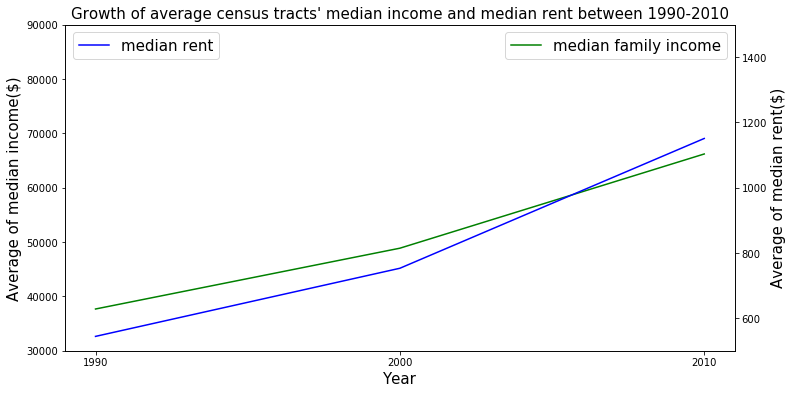

In [41]:

fig, ax1 = plt.subplots(figsize = (12, 6))
ax2 = ax1.twinx()
ax1.plot(np.arange(3), df2.mean().iloc[[0,2,4]], c = 'g', label = 'median family income')
ax2.plot(np.arange(3), df2.mean().iloc[[1,3,5]], c = 'b', label = 'median rent')
ax1.legend(loc = 'upper right', fontsize = 15)
ax2.legend(loc = 'upper left', fontsize = 15)

ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('Average of median income($)', fontsize = 15)
ax1.set_ylim((30000,90000))

ax2.set_ylabel('Average of median rent($)', fontsize = 15)
ax2.set_ylim((500, 1500))

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.title("Growth of average census tracts' median income and median rent between 1990-2010", fontsize = 15)

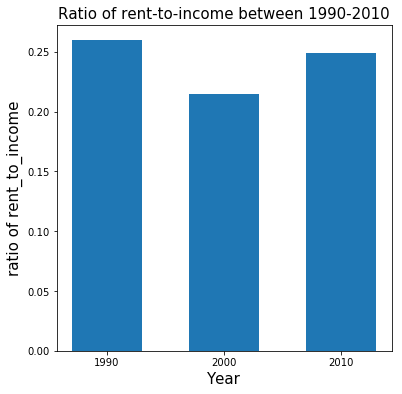

In [42]:
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df2.mean()[6:9], width = 0.6)

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('ratio of rent_to_income', fontsize = 15)
plt.title('Ratio of rent-to-income between 1990-2010', fontsize = 15)

## Calculate the change of rent between 1990-2000 and 2000-2010

In [43]:
df2['rent_growth_90_00'] = df2.median_rent_0/df2.median_rent_9
df2['rent_growth_00_10'] = df2.median_rent_1/df2.median_rent_0

df2['inc_growth_90_00'] = df2.median_inc_fam_0/df2.median_inc_fam_9
df2['inc_growth_00_10'] = df2.median_inc_fam_1/df2.median_inc_fam_0
df2.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10
1,38711,742,50817,730,58368,1273,0.230012,0.172383,0.261719,0.983827,1.743836,1.312728,1.148592
2,40484,535,41019,643,73148,1330,0.158581,0.188108,0.218188,1.201869,2.068429,1.013215,1.783271
3,24732,466,30104,558,33555,823,0.226104,0.222429,0.294323,1.197425,1.474910,1.217208,1.114636
4,24823,422,23671,461,25489,870,0.204004,0.233704,0.409588,1.092417,1.887202,0.953591,1.076803
5,18762,298,19694,266,30817,455,0.190598,0.162080,0.177175,0.892617,1.710526,1.049675,1.564791


In [44]:
df2.describe()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,37689.401628,544.198181,48874.026807,753.071326,66207.958353,1151.020105,0.259635,0.214373,0.248931,1.394707,1.554580,2.017393,1.386582
std,18760.425689,150.069074,28645.098401,231.835763,39910.826453,331.293631,2.738330,0.074864,0.100567,0.243999,0.341645,32.109538,0.371344
min,86.000000,140.000000,7354.000000,175.000000,8542.000000,231.000000,0.067760,0.010500,0.042308,0.174825,0.326599,0.536671,0.210854
25%,24924.000000,453.000000,30724.000000,644.000000,40022.000000,964.000000,0.151078,0.164954,0.181756,1.272441,1.412500,1.100910,1.155940
50%,36218.000000,531.000000,42590.000000,740.000000,56726.000000,1120.000000,0.183705,0.204193,0.235058,1.378641,1.525917,1.250178,1.336591
75%,46843.000000,629.000000,58977.000000,834.000000,80125.000000,1308.000000,0.227210,0.253730,0.300615,1.486239,1.655766,1.426565,1.545935
max,150001.000000,1001.000000,200001.000000,2001.000000,250001.000000,2001.000000,125.302326,1.194452,1.298057,4.547727,11.434286,1468.779070,4.714033


## Calculate entropy index of different income-level groups for each census tract from 1990 to 2010

In [45]:
# define entropy index 
def entropy_index(x):
    Q_sum = 0
    for i in x:
        if i == 0:
            Q = 0
        else:
            Q = (-1) * (i/sum(x)) * np.log(i/sum(x))
        Q_sum += Q
    entropy_index = Q_sum/np.log(len(x))
    return entropy_index

In [46]:
# have a try
entropy_index(list(df_family_income_1990.iloc[0,:]))

0.92246865765414721

In [47]:
# calculate the entropy index of 1990
for i in df_family_income_1990.index:
    df_family_income_1990.loc[i,'entropy_index'] = \
                    entropy_index(list(df_family_income_1990.loc[i,'fam_inc_109':'fam_inc_max_9']))

In [48]:
df_family_income_1990.head()

,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,fam_inc_609,fam_inc_759,fam_inc_1009,fam_inc_1259,fam_inc_1509,fam_inc_max_9,entropy_index
1,29,29,12,31,20,32,31,84,75,59,68,35,18,2,0.922469
2,19,17,11,34,1,50,50,89,71,58,62,28,1,1,0.863543
3,142,28,124,84,41,165,39,161,69,70,45,11,0,0,0.863912
4,50,39,0,0,3,0,0,67,26,10,0,0,0,0,0.577145
5,284,201,107,60,74,131,95,203,158,40,84,8,0,13,0.875156


In [49]:
# calculate the entropy index of 2000 and 2010
for i in df_family_income_2000.index:
    df_family_income_2000.loc[i,'entropy_index'] = \
                    entropy_index(list(df_family_income_2000.loc[i,'fam_inc_100':'fam_inc_max_200']))

for i in df_family_income_2010.index:
    df_family_income_2010.loc[i,'entropy_index'] = \
                    entropy_index(list(df_family_income_2010.loc[i,'fam_inc_101':'fam_inc_max_201']))

In [50]:
# merge the entropy index data into df2
df2['entropy_index_9'] = df_family_income_1990.iloc[:,-1]
df2['entropy_index_0'] = df_family_income_2000.iloc[:,-1]
df2['entropy_index_1'] = df_family_income_2010.iloc[:,-1]
df2.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10,entropy_index_9,entropy_index_0,entropy_index_1
1,38711,742,50817,730,58368,1273,0.230012,0.172383,0.261719,0.983827,1.743836,1.312728,1.148592,0.922469,0.871427,0.894048
2,40484,535,41019,643,73148,1330,0.158581,0.188108,0.218188,1.201869,2.068429,1.013215,1.783271,0.863543,0.914607,0.898725
3,24732,466,30104,558,33555,823,0.226104,0.222429,0.294323,1.197425,1.474910,1.217208,1.114636,0.863912,0.902281,0.894488
4,24823,422,23671,461,25489,870,0.204004,0.233704,0.409588,1.092417,1.887202,0.953591,1.076803,0.577145,0.825729,0.842364
5,18762,298,19694,266,30817,455,0.190598,0.162080,0.177175,0.892617,1.710526,1.049675,1.564791,0.875156,0.795292,0.918302


In [51]:
sum(np.array(df2 == 0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 1])

In [52]:
## delete the observation with 0 entropy index
df_census_entropy = df2[~((df2.entropy_index_9 == 0)| (df2.entropy_index_0 == 0)|\
                          (df2.entropy_index_1 == 0))]

df_census_entropy.shape

(2080, 16)

In [53]:
sum(np.array(df_census_entropy == 0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
df_census_entropy.describe()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10,entropy_index_9,entropy_index_0,entropy_index_1
count,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,37747.926923,543.339423,48664.457212,751.245673,65960.824038,1148.772596,0.198773,0.214579,0.249093,1.393492,1.550774,1.304846,1.386766,0.837531,0.878937,0.837894
std,18752.333826,149.270985,28370.962672,227.074914,39541.366903,328.446693,0.075917,0.074811,0.100533,0.235155,0.264145,0.366783,0.367756,0.076998,0.066597,0.093337
min,4999.000000,140.000000,7354.000000,195.000000,8542.000000,231.000000,0.067760,0.047473,0.042308,0.624286,0.326599,0.536671,0.210854,0.172632,0.362708,0.199940
25%,25085.750000,453.000000,30718.000000,644.000000,40016.500000,964.000000,0.150911,0.164962,0.181956,1.272691,1.412871,1.100241,1.156685,0.811590,0.854212,0.804635
50%,36235.500000,531.000000,42470.000000,740.000000,56649.500000,1120.000000,0.183664,0.204214,0.235401,1.378611,1.526301,1.248453,1.336644,0.854884,0.896428,0.860526
75%,46918.500000,629.000000,58838.250000,833.000000,80021.000000,1305.250000,0.226743,0.253890,0.300631,1.485551,1.655776,1.421796,1.546234,0.885035,0.923663,0.899776
max,150001.000000,1001.000000,200001.000000,2001.000000,250001.000000,2001.000000,0.885777,1.194452,1.298057,4.547727,4.600000,8.984771,4.714033,0.962561,0.978050,0.979375


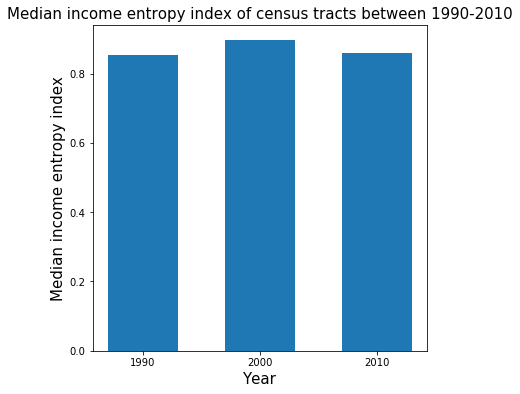

In [55]:
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df_census_entropy.median()[-3:], width = 0.6)

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Median income entropy index', fontsize = 15)
plt.title('Median income entropy index of census tracts between 1990-2010', fontsize = 15)

## OLS regression between rent growth and entropy index at the beginning point

In [56]:
lm1 = smf.ols('rent_growth_90_00 ~ entropy_index_9', df_census_entropy).fit()
lm2 = smf.ols('rent_growth_00_10 ~ entropy_index_0', df_census_entropy).fit()

In [57]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_90_00   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     14.51
Date:                Wed, 15 Nov 2017   Prob (F-statistic):           0.000144
Time:                        01:08:20   Log-Likelihood:                 67.161
No. Observations:                2080   AIC:                            -130.3
Df Residuals:                    2078   BIC:                            -119.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.6065      0.056     28.609      0.000         1.496     1.717
entropy_index_9    -0.2543      0.067     -3.809      0.000        -0.385    -0.123
==============================================================================
Omnibus:                     1262.560   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39327.293
Skew:                           2.323   Prob(JB):                         0.00
Kurtosis:                      23.789   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_00_10   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.395
Date:                Wed, 15 Nov 2017   Prob (F-statistic):             0.0655
Time:                        01:08:20   Log-Likelihood:                -180.18
No. Observations:                2080   AIC:                             364.4
Df Residuals:                    2078   BIC:                             375.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.6916      0.077     22.074      0.000         1.541     1.842
entropy_index_0    -0.1602      0.087     -1.843      0.066        -0.331     0.010
==============================================================================
Omnibus:                      858.727   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13975.251
Skew:                           1.508   Prob(JB):                         0.00
Kurtosis:                      15.335   Cond. No.                         26.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth_90to00 = -0.254 * Tract_Entropy_Index_90 + 1.606, R-squared = 0.007


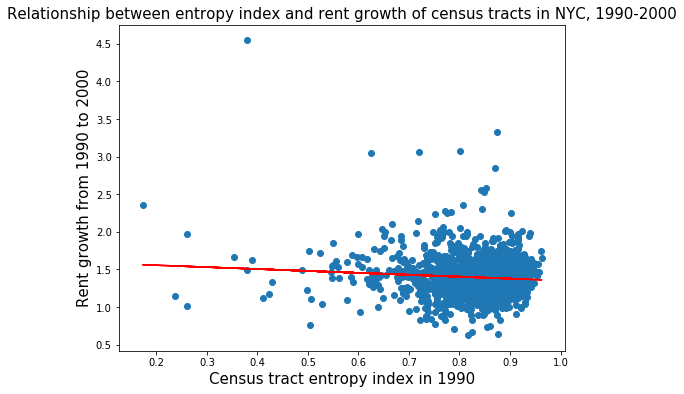

In [59]:
plt.figure(figsize = (8, 6))
plt.scatter(df_census_entropy.entropy_index_9, df_census_entropy.rent_growth_90_00)
plt.plot(df_census_entropy.entropy_index_9, lm1.predict(), c = 'r')
plt.xlabel('Census tract entropy index in 1990', fontsize = 15)
plt.ylabel('Rent growth from 1990 to 2000', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 1990-2000',
         fontsize = 15)

print('Rent_growth_90to00 = {} * Tract_Entropy_Index_90 + {}, R-squared = {}'.format(round(lm1.params[1],3),
                                                            round(lm1.params[0],3),round(lm1.rsquared,3)))

Rent_growth_00to10 = -0.16 * Tract_Entropy_Index_00 + 1.692, R-squared = 0.002


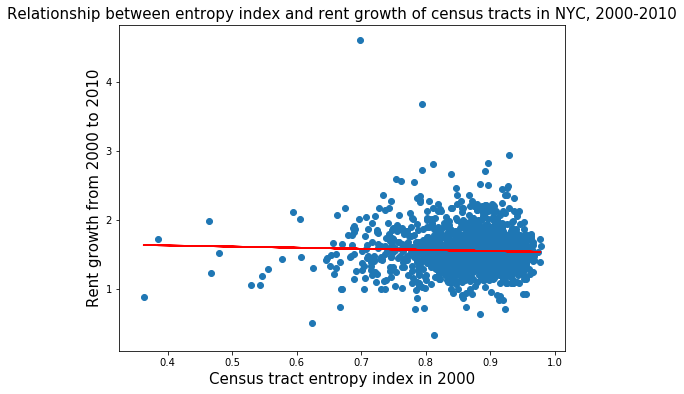

In [60]:
plt.figure(figsize = (8, 6))
plt.scatter(df_census_entropy.entropy_index_0, df_census_entropy.rent_growth_00_10)
plt.plot(df_census_entropy.entropy_index_0, lm2.predict(), c = 'r')
plt.xlabel('Census tract entropy index in 2000', fontsize = 15)
plt.ylabel('Rent growth from 2000 to 2010', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 2000-2010',
         fontsize = 15)

print('Rent_growth_00to10 = {} * Tract_Entropy_Index_00 + {}, R-squared = {}'.format(round(lm2.params[1],3),
                                                            round(lm2.params[0],3),round(lm2.rsquared,3)))

# 4.Analysis based on PUMA neighborhoods

In [61]:
df_puma_median = df_tract[['PUMA']].merge(df_census_entropy, left_index = True, right_index = True).\
                    groupby(by = 'PUMA').median()
df_puma_median.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10,entropy_index_9,entropy_index_0,entropy_index_1
PUMA,,,,,,,,,,,,,,,,
3701,32589.0,491.0,31250.0,690.0,44091.0,1085.0,0.170011,0.238615,0.262851,1.443609,1.501484,1.205806,1.304819,0.870561,0.884903,0.855084
3702,31250.0,483.0,35424.0,699.0,39470.0,1015.0,0.187676,0.236916,0.314628,1.396857,1.493617,1.129181,1.170504,0.837797,0.878405,0.863960
3703,39707.5,499.5,46226.0,688.5,65310.0,1053.0,0.161661,0.176266,0.231438,1.334670,1.549308,1.276411,1.407954,0.835450,0.877657,0.845879
3704,37100.5,496.0,47475.5,704.0,58831.0,1038.5,0.167286,0.187928,0.217722,1.386728,1.504945,1.234381,1.310854,0.852887,0.886284,0.844326
3705,18372.0,429.5,23993.5,609.0,31919.0,952.0,0.245572,0.250377,0.273214,1.377708,1.524210,1.269069,1.405541,0.814391,0.840931,0.854261


In [62]:
df_puma_median.shape 

(55, 16)

In [63]:
df_puma_family_income = df_tract[['PUMA']].merge(df_family_income, left_index = True, right_index = True).\
                    groupby(by = 'PUMA').sum()
df_puma_family_income.head()

,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,fam_inc_609,fam_inc_759,...,fam_inc_401,fam_inc_451,fam_inc_501,fam_inc_601,fam_inc_751,fam_inc_1001,fam_inc_1251,fam_inc_1501,fam_inc_2001,fam_inc_max_201
PUMA,,,,,,,,,,,,,,,,,,,,,
3701,2145,822,1017,874,748,1668,1489,3059,2046,2202,...,1052,1239,1051,2218,2916,2661,2131,1049,1061,1247
3702,3419,1255,1264,1354,1375,2520,2256,3875,2981,2426,...,2490,1550,1845,3282,3137,4123,2016,868,844,403
3703,1280,536,581,545,394,993,1053,1745,1457,1789,...,858,707,502,1067,1628,2021,1289,1110,748,563
3704,2367,1008,1205,853,1104,2130,1985,3781,2365,2939,...,1356,1564,1397,2843,3075,4377,2939,1349,1353,947
3705,4012,1306,1261,1047,785,1841,1398,2320,1744,1589,...,1819,1456,1203,1745,2595,3027,1620,1088,728,349


## calculate the PUMA entropy index of 1990, 2000 and 2010

In [64]:
for i in df_puma_family_income.index:
    df_puma_family_income.loc[i,'entropy_index_9'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_109':'fam_inc_max_9']))
    df_puma_family_income.loc[i,'entropy_index_0'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_100':'fam_inc_max_200']))
    df_puma_family_income.loc[i,'entropy_index_1'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_101':'fam_inc_max_201']))

In [65]:
df_puma_entropy = df_puma_family_income.loc[:,['entropy_index_9',
                                               'entropy_index_0','entropy_index_1']].\
                    merge(df_puma_median.loc[:, ['rent_growth_90_00', 'rent_growth_00_10']],
                         left_index = True, right_index = True)

In [66]:
df_puma_entropy.head()

,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10
PUMA,,,,,
3701,0.943952,0.954617,0.978671,1.443609,1.501484
3702,0.919729,0.925128,0.956219,1.396857,1.493617
3703,0.935463,0.953714,0.973340,1.334670,1.549308
3704,0.933677,0.957196,0.968138,1.386728,1.504945
3705,0.912003,0.906628,0.951894,1.377708,1.524210


In [67]:
df_puma_entropy.shape

(55, 5)

In [68]:
## add the PUMA district information
df_puma_entropy = df_puma_entropy.reset_index().merge(df_PUMA, on = 'PUMA' )
df_puma_entropy.head()

,PUMA,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10,PUMA_CommunityDistrict
0,3701,0.943952,0.954617,0.978671,1.443609,1.501484,BX Community District 8
1,3702,0.919729,0.925128,0.956219,1.396857,1.493617,BX Community District 12
2,3703,0.935463,0.953714,0.973340,1.334670,1.549308,BX Community District 10
3,3704,0.933677,0.957196,0.968138,1.386728,1.504945,BX Community District 11
4,3705,0.912003,0.906628,0.951894,1.377708,1.524210,BX Community Districts 3 & 6


In [69]:
df_puma_entropy.shape

(55, 7)

In [70]:
df_puma_entropy.median()

PUMA                 4005.000000
entropy_index_9         0.923605
entropy_index_0         0.951451
entropy_index_1         0.965947
rent_growth_90_00       1.377708
rent_growth_00_10       1.524210
dtype: float64

The median values of income entropy index of PUMAs in 1999, 2000 and 2010 are respectively 0.924, 0.951 and 0.966.


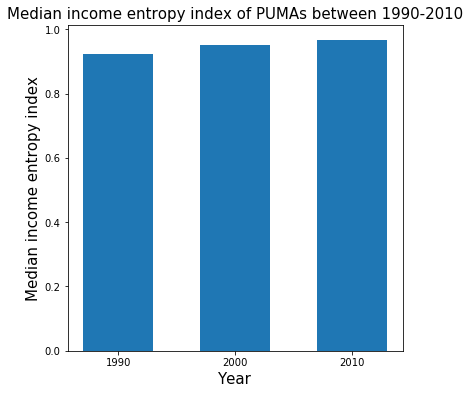

In [71]:
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df_puma_entropy.median()[1:4], width = 0.6)

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Median income entropy index', fontsize = 15)
plt.title('Median income entropy index of PUMAs between 1990-2010', fontsize = 15)

print('The median values of income entropy index of PUMAs in 1999, 2000 and 2010 are respectively {}, {} and {}.'.\
      format(round(df_puma_entropy.median()[1],3), 
             round(df_puma_entropy.median()[2],3), 
             round(df_puma_entropy.median()[3],3)))

## The income entropy index of PUMAs increased in the 20 years, meaning the level of neighborhood income integration in total has increased

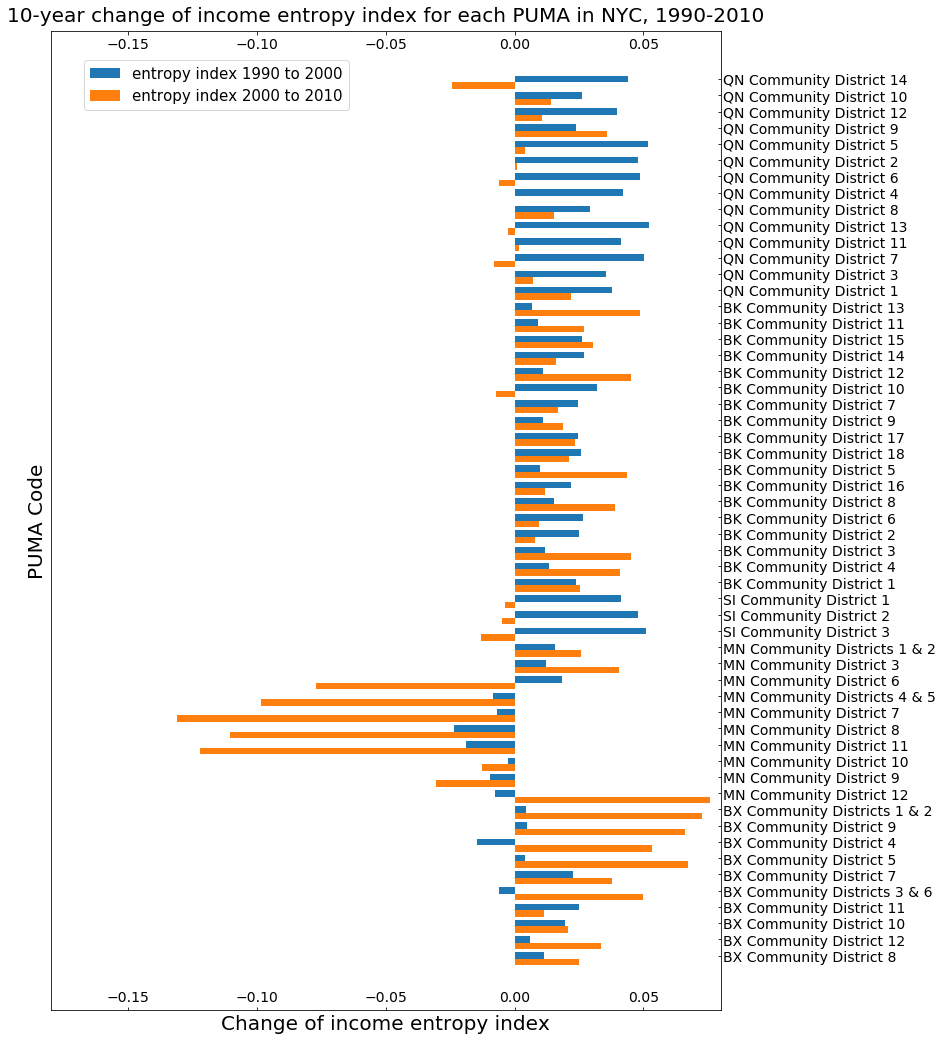

In [72]:
plt.figure(figsize = (12,18))
plt.barh(np.arange(len(df_puma_entropy)), 
         width = df_puma_entropy.entropy_index_0/df_puma_entropy.entropy_index_9 - 1,
        height = 0.4, label = 'entropy index 1990 to 2000')
plt.barh(np.arange(len(df_puma_entropy)) - 0.4, 
         width = df_puma_entropy.entropy_index_1/df_puma_entropy.entropy_index_0 - 1,
        height = 0.4, label = 'entropy index 2000 to 2010')
plt.xlim((-0.18,0.08))
plt.tick_params(axis='x', pad= -20, labelsize=14, direction = 'in', 
                top = True, bottom = True, labeltop= True, labelbottom = True)
plt.yticks(np.arange(len(df_puma_entropy)),df_puma_entropy.PUMA_CommunityDistrict )
plt.tick_params(axis='y', pad=2, labelsize=14, direction = 'in', 
               left = False, right = True, labelleft = False, labelright = True)

plt.ylabel('PUMA Code',fontsize = 20)
plt.xlabel('Change of income entropy index', fontsize = 20)
plt.title('10-year change of income entropy index for each PUMA in NYC, 1990-2010',fontsize = 20,
         verticalalignment='bottom')

plt.legend(loc = (0.05, 0.92), fontsize = 15)
plt.show()

## If we look at different PUMAs, the change of income entropy index varies, especially in Manhattan and Brooklyn.  
## In Manhattan, most of the entropy index continued to decrease in 20 years, even getting worse in the latter decade.
## On the contrary, in brooklyn, most of the entropy index continued to increase in 20 years, with greater growth rate in the latter decade.

In [73]:
lm1_puma = smf.ols('rent_growth_90_00 ~ entropy_index_9', df_puma_entropy).fit()
lm2_puma = smf.ols('rent_growth_00_10 ~ entropy_index_0', df_puma_entropy).fit()

In [74]:
lm1_puma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_90_00   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.5743
Date:                Wed, 15 Nov 2017   Prob (F-statistic):              0.452
Time:                        01:08:23   Log-Likelihood:                 49.046
No. Observations:                  55   AIC:                            -94.09
Df Residuals:                      53   BIC:                            -90.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.9690      0.564      1.717      0.092        -0.163     2.101
entropy_index_9     0.4642      0.612      0.758      0.452        -0.764     1.693
==============================================================================
Omnibus:                       20.264   Durbin-Watson:                   0.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.113
Skew:                           1.386   Prob(JB):                     1.30e-06
Kurtosis:                       5.036   Cond. No.                         83.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
lm2_puma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_00_10   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     6.065
Date:                Wed, 15 Nov 2017   Prob (F-statistic):             0.0171
Time:                        01:08:23   Log-Likelihood:                 90.889
No. Observations:                  55   AIC:                            -177.8
Df Residuals:                      53   BIC:                            -173.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.0446      0.196      5.339      0.000         0.652     1.437
entropy_index_0     0.5125      0.208      2.463      0.017         0.095     0.930
==============================================================================
Omnibus:                        3.410   Durbin-Watson:                   1.205
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                2.365
Skew:                           0.330   Prob(JB):                        0.307
Kurtosis:                       2.228   Cond. No.                         61.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth_90to00 = 0.969 + 0.464 * PUMA_Entropy_Index_90, R-squared = 0.011


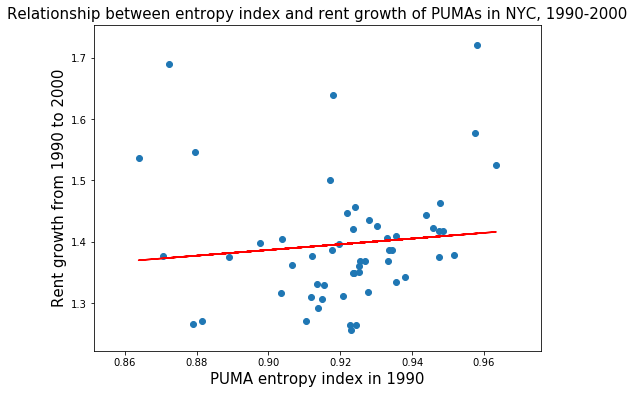

In [76]:
plt.figure(figsize = (8, 6))
plt.scatter(df_puma_entropy.entropy_index_9, df_puma_entropy.rent_growth_90_00)
plt.plot(df_puma_entropy.entropy_index_9, lm1_puma.predict(), c = 'r')
plt.xlabel('PUMA entropy index in 1990', fontsize = 15)
plt.ylabel('Rent growth from 1990 to 2000', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of PUMAs in NYC, 1990-2000',
         fontsize = 15)

print('Rent_growth_90to00 = {} + {} * PUMA_Entropy_Index_90, R-squared = {}'.format(\
                round(lm1_puma.params[0],3), round(lm1_puma.params[1],3),round(lm1_puma.rsquared,3)))

Rent_growth_00to10 = 1.045 + 0.513 * PUMA_Entropy_Index_00, R-squared = 0.103


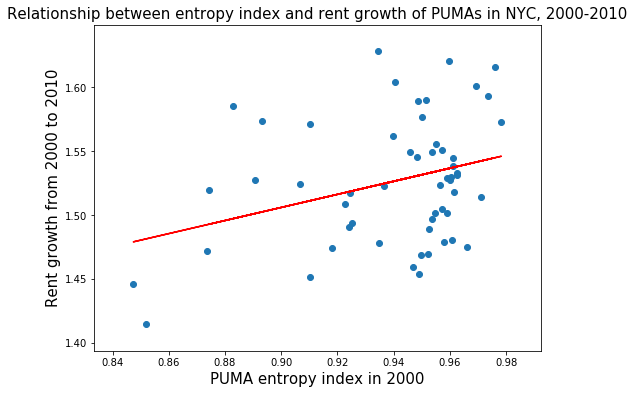

In [77]:
plt.figure(figsize = (8, 6))
plt.scatter(df_puma_entropy.entropy_index_0, df_puma_entropy.rent_growth_00_10)
plt.plot(df_puma_entropy.entropy_index_0, lm2_puma.predict(), c = 'r')
plt.xlabel('PUMA entropy index in 2000', fontsize = 15)
plt.ylabel('Rent growth from 2000 to 2010', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of PUMAs in NYC, 2000-2010',
         fontsize = 15)

print('Rent_growth_00to10 = {} + {} * PUMA_Entropy_Index_00, R-squared = {}'.format(\
                round(lm2_puma.params[0],3), round(lm2_puma.params[1],3),round(lm2_puma.rsquared,3)))